In [2]:
# ENVIRONMENT SETUP
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Spark Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, count, lit, when, isnan, desc, size
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window
from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix
from pyspark.mllib.linalg import Vectors

# Initialize Spark with Memory Config
spark = SparkSession.builder \
    .appName("AmazonPageRank_Analysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

# Authentication & Download
try:
    from google.colab import userdata
    os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
    os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
except:
    print("⚠️ Credentials not found in Secrets. Ensure kaggle.json is uploaded manually.")

print("⬇️ Downloading Dataset...")
!pip install -q kaggle
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip -q -o amazon-books-reviews.zip
print("✅ Setup Complete.")

⬇️ Downloading Dataset...
Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 98% 1.04G/1.06G [00:05<00:00, 183MB/s]
100% 1.06G/1.06G [00:07<00:00, 158MB/s]
✅ Setup Complete.


In [21]:
# 1. LOAD & INSPECT (The "Why")

def load_and_inspect_data(path):
    """ Loads data and prints a 'Health Check' table before cleaning. """
    print(f"Loading '{path}'...")
    start_t = time.time()
    df = spark.read.csv(path, header=True, inferSchema=True)
    count_raw = df.count()

    print(f"-> Initial Record Count: {count_raw:,}")

    # --- VISUAL INSPECTION
    print("\n[DATA PROFILE] Checking for dirty data...")
    print("1. Schema Structure:")
    df.printSchema()

    print("2. Missing Value Check (Rows with Nulls):")
    df.select([count(when(col(c).isNull(), c)).alias(c)
               for c in ["User_id", "Title", "review/helpfulness"]]).show()

    print("3. Helpfulness Format Sample (Before Parsing):")
    df.select("review/helpfulness").sample(False, 0.0001, seed=42).show(3)
    # ------------------------------------------------

    return df, count_raw


# 2.CLEANING  (The "How")

def clean_data(df, raw_count):
    """ Cleans nulls, duplicates, and parses specific columns. """
    print("\n=== PHASE 2: CLEANING & PARSING ===")

    # Drop Garbage
    df = df.dropna(subset=["User_id", "Title"])
    df = df.dropDuplicates(subset=["User_id", "Title"])

    # Parse "x/y" Helpfulness Format
    valid_pattern = r"^\d+/\d+$"
    df = df.withColumn("helpful_votes",
            when(col("review/helpfulness").rlike(valid_pattern),
                 split(col("review/helpfulness"), "/").getItem(0).cast(IntegerType())).otherwise(0)) \
           .withColumn("total_votes",
            when(col("review/helpfulness").rlike(valid_pattern),
                 split(col("review/helpfulness"), "/").getItem(1).cast(IntegerType())).otherwise(0))

    new_count = df.count()
    print(f"-> Cleaned Rows: {new_count:,}")
    print(f"-> Dropped {raw_count - new_count:,} bad records ({(raw_count - new_count)/raw_count:.1%} of data)")
    return df

def apply_topology_filter(df, min_user=3, min_book=5):
    """ Filters graph to keep only the dense 'core' community. """
    print(f"\n=== PHASE 3: TOPOLOGY FILTERING (k-core) ===")
    print(f"Keeping Users w/ >={min_user} reviews, Books w/ >={min_book} reviews...")

    # Filter Books First (must be bridges)
    w_book = Window.partitionBy("Title")
    df = df.withColumn("book_revs", count("User_id").over(w_book)).filter(col("book_revs") >= min_book)

    # Filter Users Second (must be active)
    w_user = Window.partitionBy("User_id")
    df = df.withColumn("user_revs", count("Title").over(w_user)).filter(col("user_revs") >= min_user)

    dense_count = df.count()
    print(f"-> Dense Graph Size: {dense_count:,} reviews")
    return df, dense_count

def build_graph(df, current_count, target=80000):
    """ Samples data if necessary and generates edge list. """
    print("\n=== PHASE 4: GRAPH CONSTRUCTION ===")

    # Smart Sampling to prevent RAM crash
    if current_count > target:
        frac = target / current_count
        print(f"-> Dataset too large for Colab RAM. Sampling {frac:.1%}...")
        df = df.sample(withReplacement=False, fraction=frac, seed=42)

    final_count = df.count()
    print(f"-> Final Node Count (Reviews): {final_count:,}")

    print("Generating Edges (User-to-User based on shared Books)...")
    # RESTORED: Using '!=' creates bidirectional edges (2M edges), increasing complexity.
    edges = df.alias("a").join(df.alias("b"), on="Title", how="inner") \
              .where(col("a.User_id") != col("b.User_id")) \
              .select(col("a.User_id").alias("src"), col("b.User_id").alias("dst")) \
              .distinct()

    edge_count = edges.count()
    print(f"-> Edges Created: {edge_count:,}")
    return df, edges


# 3. EXECUTE PIPELINE

# A. Load & Inspect
df_raw, raw_size = load_and_inspect_data("Books_rating.csv")

# B. Clean
df_clean = clean_data(df_raw, raw_size)

# C. Apply graph theory filters
df_dense, dense_size = apply_topology_filter(df_clean)

# D. Build the final graph objects
df_final, df_edges = build_graph(df_dense, dense_size)

Loading 'Books_rating.csv'...
-> Initial Record Count: 3,000,000

[DATA PROFILE] Checking for dirty data...
1. Schema Structure:
root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: string (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)

2. Missing Value Check (Rows with Nulls):
+-------+-----+------------------+
|User_id|Title|review/helpfulness|
+-------+-----+------------------+
| 562250|  208|               367|
+-------+-----+------------------+

3. Helpfulness Format Sample (Before Parsing):
+------------------+
|review/helpfulness|
+------------------+
|               0/0|
|               0/0|
|               0/0|
+------------------+
only showing top 3 rows

=== PHASE 2:


--- Graph Topology Analysis ---
Total Reviews: 79,708
Nodes (Users): 41,260
Edges (Links): 2,028,440
Avg Degree:    49.16


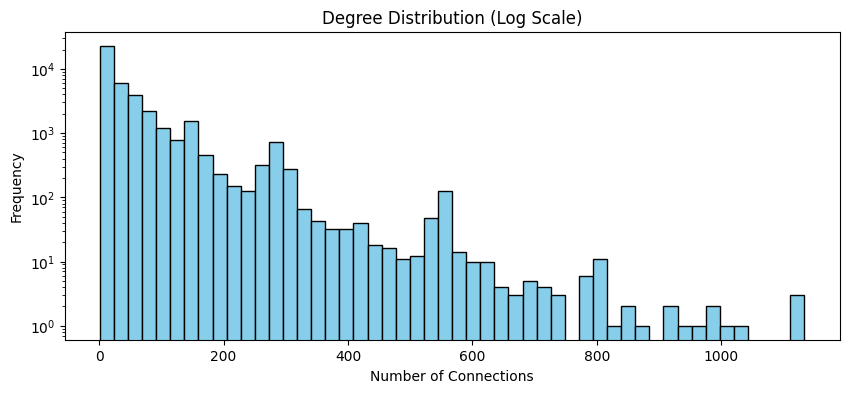


Building Distributed Transition Matrix...


In [22]:
# MATRIX CONSTRUCTION & ANALYSIS

def analyze_graph_structure(edges_df, reviews_df):
    """
    Calculates basic graph statistics to justify the PageRank approach.
    """
    print("\n--- Graph Topology Analysis ---")
    # Count metrics
    review_count = reviews_df.count()
    node_count = edges_df.select("src").union(edges_df.select("dst")).distinct().count()
    edge_count = edges_df.count()

    # Calculate density
    avg_degree = edge_count / node_count if node_count > 0 else 0

    print(f"Total Reviews: {review_count:,}") # <--- Added this!
    print(f"Nodes (Users): {node_count:,}")
    print(f"Edges (Links): {edge_count:,}")
    print(f"Avg Degree:    {avg_degree:.2f}")

    # Degree Distribution Plot
    degrees = edges_df.groupBy("src").count().rdd.map(lambda r: r['count']).collect()
    plt.figure(figsize=(10, 4))
    plt.hist(degrees, bins=50, log=True, color='skyblue', edgecolor='black')
    plt.title("Degree Distribution (Log Scale)")
    plt.xlabel("Number of Connections")
    plt.ylabel("Frequency")
    plt.show()
    return node_count

def build_distributed_matrix(edges_df, node_count):
    """
    Constructs the Transposed Transition Matrix (M^T) using Spark RDDs.
    """
    print("\nBuilding Distributed Transition Matrix...")

    # Map IDs to Integers
    nodes = edges_df.select("src").union(edges_df.select("dst")).distinct()
    user_to_id = nodes.rdd.map(lambda r: r.src).zipWithIndex().collectAsMap()
    id_to_user = {v: k for k, v in user_to_id.items()}

    # Broadcast for efficiency
    bc_user_to_id = sc.broadcast(user_to_id)

    # Calculate Out-Degrees
    out_degrees = edges_df.groupBy("src").count().rdd \
        .map(lambda r: (bc_user_to_id.value[r.src], r['count'])).collectAsMap()
    bc_out_degrees = sc.broadcast(out_degrees)

    # Matrix Row Builder
    def build_rows(row):
        dst_id, src_list = row
        sorted_src = sorted(src_list) # Required for SparseVector
        vals = [1.0 / bc_out_degrees.value.get(s, 1) for s in sorted_src]
        return IndexedRow(dst_id, Vectors.sparse(node_count, sorted_src, vals))

    # RDD Transformation
    matrix = IndexedRowMatrix(
        edges_df.rdd.map(lambda r: (bc_user_to_id.value[r.dst], bc_user_to_id.value[r.src]))
        .groupByKey().map(build_rows)
    )

    return matrix, bc_user_to_id, id_to_user

# --- EXECUTE ---
# We pass 'df_final' here to get the review count
n_users = analyze_graph_structure(df_edges, df_final)
M_transposed, bc_mapping, id_map = build_distributed_matrix(df_edges, n_users)

In [23]:
# PAGERANK ENGINE (FROM SCRATCH)

def pagerank_solver(matrix, n_nodes, beta=0.85, max_iter=10, topic_vector=None):
    """
    Implements the PageRank Power Iteration Method using Spark RDDs.
    Supports both Standard (Uniform) and Topic-Sensitive (Biased) teleportation.
    """
    # 1. Initialize Ranks Uniformly (r_0)
    ranks = np.ones(n_nodes) / n_nodes
    convergence = []

    # 2. Define Teleportation Vector (v)
    if topic_vector is not None:
        print(f"Initializing Topic-Sensitive Teleport (Bias Pool: {len(topic_vector)} nodes)...")
        teleport = np.zeros(n_nodes)
        bias_val = (1.0 - beta) / len(topic_vector)
        for idx in topic_vector:
            teleport[idx] = bias_val
    else:
        print("Initializing Standard Uniform Teleport...")
        teleport = np.ones(n_nodes) * (1.0 - beta) / n_nodes

    # 3. Power Iteration Loop
    print(f"Starting Iterations (Beta={beta})...")
    start_time = time.time()

    for i in range(max_iter):
        ranks_bc = sc.broadcast(ranks)

        # Distributed Matrix-Vector Multiplication: M^T * r
        # flatMap not needed here because IndexedRowMatrix handles dot product via map
        updates = matrix.rows.map(
            lambda r: (r.index, r.vector.dot(ranks_bc.value))
        ).collect()

        # Reconstruct vector on driver
        M_times_r = np.zeros(n_nodes)
        for idx, val in updates:
            M_times_r[idx] = val

        # The Equation: r_new = beta * (M^T * r) + teleport
        new_ranks = (beta * M_times_r) + teleport

        # Calculate Error
        error = np.linalg.norm(new_ranks - ranks)
        convergence.append(error)
        print(f"   Iter {i+1}: Error = {error:.6f}")

        ranks = new_ranks

    print(f"Converged in {time.time() - start_time:.2f} seconds.")
    return ranks, convergence

# DEFINE TRUSTED USERS (For Topic-Sensitive Variant)
print("\nDefining 'Trusted Voice' Set...")
trusted_df = df_final.groupBy("User_id") \
    .sum("helpful_votes", "total_votes") \
    .filter((col("sum(total_votes)") > 5) & ((col("sum(helpful_votes)") / col("sum(total_votes)")) > 0.8))

trusted_user_ids = [row.User_id for row in trusted_df.collect()]
# Map string IDs to integers
trusted_indices = [bc_mapping.value[u] for u in trusted_user_ids if u in bc_mapping.value]

# --- RUN EXPERIMENTS ---
print("\n=== EXPERIMENT 1: STANDARD PAGERANK ===")
scores_std, hist_std = pagerank_solver(M_transposed, n_users)

print("\n=== EXPERIMENT 2: TOPIC-SENSITIVE PAGERANK ===")
scores_topic, hist_topic = pagerank_solver(M_transposed, n_users, topic_vector=trusted_indices)


Defining 'Trusted Voice' Set...

=== EXPERIMENT 1: STANDARD PAGERANK ===
Initializing Standard Uniform Teleport...
Starting Iterations (Beta=0.85)...
   Iter 1: Error = 0.004919
   Iter 2: Error = 0.001538
   Iter 3: Error = 0.000406
   Iter 4: Error = 0.000310
   Iter 5: Error = 0.000205
   Iter 6: Error = 0.000158
   Iter 7: Error = 0.000121
   Iter 8: Error = 0.000096
   Iter 9: Error = 0.000077
   Iter 10: Error = 0.000062
Converged in 116.11 seconds.

=== EXPERIMENT 2: TOPIC-SENSITIVE PAGERANK ===
Initializing Topic-Sensitive Teleport (Bias Pool: 6272 nodes)...
Starting Iterations (Beta=0.85)...
   Iter 1: Error = 0.005471
   Iter 2: Error = 0.001592
   Iter 3: Error = 0.000608
   Iter 4: Error = 0.000453
   Iter 5: Error = 0.000355
   Iter 6: Error = 0.000283
   Iter 7: Error = 0.000238
   Iter 8: Error = 0.000195
   Iter 9: Error = 0.000167
   Iter 10: Error = 0.000137
Converged in 107.90 seconds.


Fetching metadata from dense graph...

=== TOP 10: STANDARD PAGERANK (POPULARITY) ===
Rank  | User ID         | Score     | True Revs | Helpful  | Trust %
---------------------------------------------------------------------------
1     | A1K1JW1C5CUSUZ  | 0.00063   | 1025      | 20775/22940 | 90.6%  
2     | AFVQZQ8PW0L     | 0.00062   | 2715      | 15895/20703 | 76.8%  
3     | A1EKTLUL24HDG8  | 0.00050   | 570       | 2846/3226  | 88.2%  
4     | A1X8VZWTOG8IS6  | 0.00049   | 1287      | 606/2956  | 20.5%  
5     | A14OJS0VWMOSWO  | 0.00045   | 3118      | 19871/23666 | 84.0%  
6     | A1N1YEMTI9DJ86  | 0.00043   | 771       | 2517/3085  | 81.6%  
7     | A1D2C0WDCSHUWZ  | 0.00042   | 701       | 7219/8152  | 88.6%  
8     | A20VXF9DYI0I6H  | 0.00038   | 139       | 1111/1409  | 78.9%  
9     | A370Z6I5GBWU44  | 0.00036   | 403       | 259/270   | 95.9%  
10    | AHD101501WCN1   | 0.00035   | 1091      | 7699/10845 | 71.0%  

=== TOP 10: TRUSTED-VOICE PAGERANK (QUALITY) ===
Rank  | 

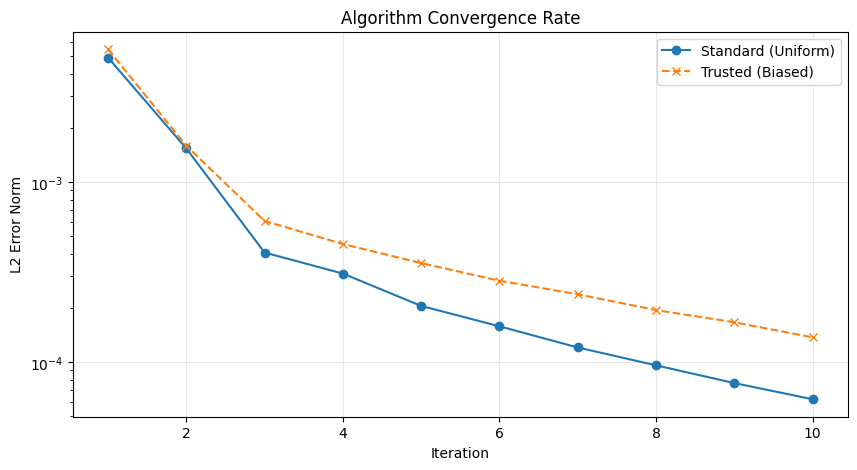

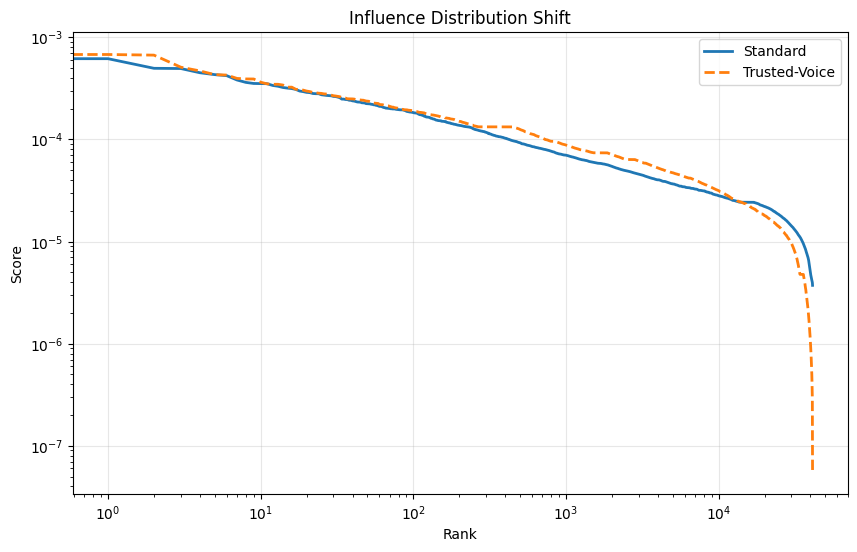

In [24]:
# RESULTS & VISUALIZATION (FINAL)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, sum as spark_sum, count

def get_true_user_stats(user_ids_list):
    """
    Fetches activity metrics from the DENSE (pre-sampled) dataset.
    This reveals the true influence of users before downsampling.
    """
    # Using df_dense instead of df_final to get TRUE counts
    stats_df = df_dense.filter(col("User_id").isin(user_ids_list)) \
        .groupBy("User_id") \
        .agg(
            count("Title").alias("review_count"),
            spark_sum("helpful_votes").alias("total_helpful"),
            spark_sum("total_votes").alias("all_votes")
        ).collect()

    stats_map = {}
    for row in stats_df:
        ratio = (row.total_helpful / row.all_votes) if row.all_votes > 0 else 0.0
        stats_map[row.User_id] = {
            "reviews": row.review_count,
            "helpful": row.total_helpful,
            "total": row.all_votes,
            "ratio": ratio
        }
    return stats_map

# 1. EXTRACT TOP USERS
print("Fetching metadata from dense graph...")

# Sort indices
top_10_std_idx = np.argsort(scores_std)[::-1][:10]
top_10_topic_idx = np.argsort(scores_topic)[::-1][:10]

# Map to IDs
top_10_std_ids = [id_map[i] for i in top_10_std_idx]
top_10_topic_ids = [id_map[i] for i in top_10_topic_idx]

# Fetch stats
all_top_ids = list(set(top_10_std_ids + top_10_topic_ids))
user_stats = get_true_user_stats(all_top_ids)

# 2. PRINT TABLES
def print_rich_table(title, indices, ranks, stats):
    print(f"\n=== {title} ===")
    print(f"{'Rank':<5} | {'User ID':<15} | {'Score':<9} | {'True Revs':<9} | {'Helpful':<8} | {'Trust %':<7}")
    print("-" * 75)

    for i, idx in enumerate(indices):
        uid = id_map[idx]
        score = ranks[idx]
        u_stat = stats.get(uid, {"reviews":0, "helpful":0, "total":0, "ratio":0})
        trust_pct = f"{u_stat['ratio']*100:.1f}%"

        print(f"{i+1:<5} | {uid:<15} | {score:.5f}   | {u_stat['reviews']:<9} | {u_stat['helpful']}/{u_stat['total']:<5} | {trust_pct:<7}")

print_rich_table("TOP 10: STANDARD PAGERANK (POPULARITY)", top_10_std_idx, scores_std, user_stats)
print_rich_table("TOP 10: TRUSTED-VOICE PAGERANK (QUALITY)", top_10_topic_idx, scores_topic, user_stats)

# 3. STABILITY ANALYSIS
print("\n=== ALGORITHM STABILITY ANALYSIS ===")
std_final_delta = hist_std[-1]
topic_final_delta = hist_topic[-1]
stability_ratio = topic_final_delta / std_final_delta

print(f"Standard Final Error:  {std_final_delta:.7f}")
print(f"Trusted Final Error:   {topic_final_delta:.7f}")
print(f"Volatility Factor:     {stability_ratio:.2f}x")

# 4. PLOTS

# Convergence
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), hist_std, 'o-', label='Standard (Uniform)')
plt.plot(range(1, 11), hist_topic, 'x--', label='Trusted (Biased)')
plt.yscale('log')
plt.title('Algorithm Convergence Rate')
plt.xlabel('Iteration'); plt.ylabel('L2 Error Norm')
plt.legend(); plt.grid(True, alpha=0.3)
plt.savefig('convergence.png', dpi=150)
plt.show()

# Lift
plt.figure(figsize=(10, 6))
plt.plot(sorted(scores_std, reverse=True), label='Standard', linewidth=2)
plt.plot(sorted(scores_topic, reverse=True), label='Trusted-Voice', linewidth=2, linestyle='--')
plt.yscale('log'); plt.xscale('log')
plt.title('Influence Distribution Shift')
plt.xlabel('Rank'); plt.ylabel('Score')
plt.legend(); plt.grid(True, alpha=0.3)
plt.savefig('lift.png', dpi=150)
plt.show()